Renderizando frame 1/1 (100.0%)


┌ Info: Saved animation to c:\Users\giost\OneDrive\Escritorio\Pro-Fac\LENTES GRAVITATORIOS A PARTIR DE RAY TRAICING GEODECICO\Precentacion\agujero_negro_RK45.gif
└ @ Plots C:\Users\giost\.julia\packages\Plots\bpxfB\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\giost\\OneDrive\\Escritorio\\Pro-Fac\\LENTES GRAVITATORIOS A PARTIR DE RAY TRAICING GEODECICO\\Precentacion\\agujero_negro_RK45.gif")
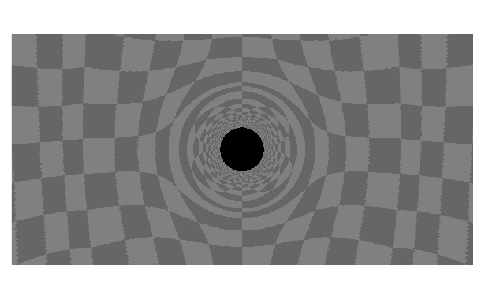

In [ ]:
using Plots
using LinearAlgebra
using Colors
using Printf

gr() 

# --- COEFICIENTES DORMAND-PRINCE (RK45) ---
const C2, C3, C4, C5, C6 = 1/5, 3/10, 4/5, 8/9, 1.0
const A21 = 1/5
const A31, A32 = 3/40, 9/40
const A41, A42, A43 = 44/45, -56/15, 32/9
const A51, A52, A53, A54 = 19372/6561, -25360/2187, 64448/6561, -212/729
const A61, A62, A63, A64, A65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
const B1, B3, B4, B5, B6 = 35/384, 500/1113, 125/192, -2187/6784, 11/84
const E1, E3, E4, E5, E6, E7 = 71/57600, -71/16695, 71/1920, -17253/339200, 22/525, -1/40

# --- 1. PARÁMETROS GLOBALES ---
const ALTO = 400
const ANCHO = 800
const RS_VAL = 1.0 
const MAX_STEPS = 500 
const DT = 0.05     

# --- 2. FÍSICA ---

mutable struct Ray
    vel::Float64
    Position::Vector{Float64}
    direc::Vector{Float64}
    r::Float64
    θ::Float64
    ϕ::Float64
    dr::Float64
    dθ::Float64
    dϕ::Float64
end

function crear_ray(c, Position, direc)
    x, y, z = Position
    r = sqrt(x^2 + y^2 + z^2)

    z_clamped = clamp(z/r, -1+eps(), 1-eps())
    θ = acos(z_clamped)
    ϕ = atan(y, x)
    

    dr = (direc[1]*x + direc[2]*y + direc[3]*z) / r
    denom_theta = (r^2 * sqrt(1 - z_clamped^2))
    dθ = (z*dr - r*direc[3]) / denom_theta
    dϕ = (-direc[1]*y + direc[2]*x) / (x^2 + y^2)
    
    return Ray(c, Position, direc, r, θ, ϕ, dr, dθ, dϕ)
end

function normalized(direc)
    n = norm(direc)
    return [direc[1]/n, direc[2]/n, direc[3]/n]
end







function geodesic_equations(ray::Ray, rs)
    r = ray.r
    θ = ray.θ
    ϕ = ray.ϕ
    dr = ray.dr
    dθ = ray.dθ
    dϕ = ray.dϕ
    
    
    if r > rs
        f = 1.0 - rs/r
        
        d2r = (rs/(2*r^2)) * (1 - rs/r)^(-1) * dr^2 + 
              r * (1 - rs/r) * (dθ^2 + sin(θ)^2 * dϕ^2) -
              (rs/(2*r^2)) * (1 - rs/r)
        
        d2θ = -2.0 * dr * dθ / r + sin(θ) * cos(θ) * dϕ^2
        
        d2ϕ = -2.0 * dr * dϕ / r - 2.0 * cos(θ) * dθ * dϕ / sin(θ)
    else
        d2r = -rs / (2.0 * r^2)
        d2θ = 0.0
        d2ϕ = 0.0
    end
    
    return d2r, d2θ, d2ϕ
end
function geodesic_equations_med(r ,θ ,ϕ ,dr ,dθ ,dϕ , rs)

    if r > rs
        f = 1.0 - rs/r
        
        # Ecuaciones corregidas para métrica de Schwarzschild
        d2r = (rs/(2*r^2)) * (1 - rs/r)^(-1) * dr^2 + 
              r * (1 - rs/r) * (dθ^2 + sin(θ)^2 * dϕ^2) -
              (rs/(2*r^2)) * (1 - rs/r)
        
        d2θ = -2.0 * dr * dθ / r + sin(θ) * cos(θ) * dϕ^2
        
        d2ϕ = -2.0 * dr * dϕ / r - 2.0 * cos(θ) * dθ * dϕ / sin(θ)
    else
        d2r = -rs / (2.0 * r^2)
        d2θ = 0.0
        d2ϕ = 0.0
    end
    
    return d2r, d2θ, d2ϕ
end
function step!(ray, dt, R_s, tol=1e-10)
    
    # Estado inicial
    r, θ, ϕ = ray.r, ray.θ, ray.ϕ
    dr, dθ, dϕ = ray.dr, ray.dθ, ray.dϕ

    # Función auxiliar para evaluar derivadas (velocidad -> aceleración)
    function get_k(tr, tθ, tϕ, tdr, tdθ, tdϕ)
        acc_r, acc_θ, acc_ϕ = geodesic_equations_med(tr, tθ, tϕ, tdr, tdθ, tdϕ, R_s)
        return tdr, tdθ, tdϕ, acc_r, acc_θ, acc_ϕ
    end

    # --- ETAPA 1 (k1) ---
    k1_r, k1_θ, k1_ϕ, k1_vr, k1_vθ, k1_vϕ = get_k(r, θ, ϕ, dr, dθ, dϕ)

    # --- ETAPA 2 (k2) ---
    r2  = r  + dt * (A21 * k1_r)
    θ2  = θ  + dt * (A21 * k1_θ)
    ϕ2  = ϕ  + dt * (A21 * k1_ϕ)
    vr2 = dr + dt * (A21 * k1_vr)
    vθ2 = dθ + dt * (A21 * k1_vθ)
    vϕ2 = dϕ + dt * (A21 * k1_vϕ)
    k2_r, k2_θ, k2_ϕ, k2_vr, k2_vθ, k2_vϕ = get_k(r2, θ2, ϕ2, vr2, vθ2, vϕ2)

    # --- ETAPA 3 (k3) ---
    r3  = r  + dt * (A31 * k1_r + A32 * k2_r)
    θ3  = θ  + dt * (A31 * k1_θ + A32 * k2_θ)
    ϕ3  = ϕ  + dt * (A31 * k1_ϕ + A32 * k2_ϕ)
    vr3 = dr + dt * (A31 * k1_vr + A32 * k2_vr)
    vθ3 = dθ + dt * (A31 * k1_vθ + A32 * k2_vθ)
    vϕ3 = dϕ + dt * (A31 * k1_vϕ + A32 * k2_vϕ)
    k3_r, k3_θ, k3_ϕ, k3_vr, k3_vθ, k3_vϕ = get_k(r3, θ3, ϕ3, vr3, vθ3, vϕ3)

    # --- ETAPA 4 (k4) ---
    r4  = r  + dt * (A41 * k1_r + A42 * k2_r + A43 * k3_r)
    θ4  = θ  + dt * (A41 * k1_θ + A42 * k2_θ + A43 * k3_θ)
    ϕ4  = ϕ  + dt * (A41 * k1_ϕ + A42 * k2_ϕ + A43 * k3_ϕ)
    vr4 = dr + dt * (A41 * k1_vr + A42 * k2_vr + A43 * k3_vr)
    vθ4 = dθ + dt * (A41 * k1_vθ + A42 * k2_vθ + A43 * k3_vθ)
    vϕ4 = dϕ + dt * (A41 * k1_vϕ + A42 * k2_vϕ + A43 * k3_vϕ)
    k4_r, k4_θ, k4_ϕ, k4_vr, k4_vθ, k4_vϕ = get_k(r4, θ4, ϕ4, vr4, vθ4, vϕ4)

    # --- ETAPA 5 (k5) ---
    r5  = r  + dt * (A51 * k1_r + A52 * k2_r + A53 * k3_r + A54 * k4_r)
    θ5  = θ  + dt * (A51 * k1_θ + A52 * k2_θ + A53 * k3_θ + A54 * k4_θ)
    ϕ5  = ϕ  + dt * (A51 * k1_ϕ + A52 * k2_ϕ + A53 * k3_ϕ + A54 * k4_ϕ)
    vr5 = dr + dt * (A51 * k1_vr + A52 * k2_vr + A53 * k3_vr + A54 * k4_vr)
    vθ5 = dθ + dt * (A51 * k1_vθ + A52 * k2_vθ + A53 * k3_vθ + A54 * k4_vθ)
    vϕ5 = dϕ + dt * (A51 * k1_vϕ + A52 * k2_vϕ + A53 * k3_vϕ + A54 * k4_vϕ)
    k5_r, k5_θ, k5_ϕ, k5_vr, k5_vθ, k5_vϕ = get_k(r5, θ5, ϕ5, vr5, vθ5, vϕ5)

    # --- ETAPA 6 (k6) ---
    r6  = r  + dt * (A61 * k1_r + A62 * k2_r + A63 * k3_r + A64 * k4_r + A65 * k5_r)
    θ6  = θ  + dt * (A61 * k1_θ + A62 * k2_θ + A63 * k3_θ + A64 * k4_θ + A65 * k5_θ)
    ϕ6  = ϕ  + dt * (A61 * k1_ϕ + A62 * k2_ϕ + A63 * k3_ϕ + A64 * k4_ϕ + A65 * k5_ϕ)
    vr6 = dr + dt * (A61 * k1_vr + A62 * k2_vr + A63 * k3_vr + A64 * k4_vr + A65 * k5_vr)
    vθ6 = dθ + dt * (A61 * k1_vθ + A62 * k2_vθ + A63 * k3_vθ + A64 * k4_vθ + A65 * k5_vθ)
    
    # LA LÍNEA SIGUIENTE FALTABA:
    vϕ6 = dϕ + dt * (A61 * k1_vϕ + A62 * k2_vϕ + A63 * k3_vϕ + A64 * k4_vϕ + A65 * k5_vϕ)
    
    k6_r, k6_θ, k6_ϕ, k6_vr, k6_vθ, k6_vϕ = get_k(r6, θ6, ϕ6, vr6, vθ6, vϕ6)

    # --- SOLUCIÓN DE ORDEN 5 (Actualización) ---
    r_new  = r  + dt * (B1*k1_r  + B3*k3_r  + B4*k4_r  + B5*k5_r  + B6*k6_r)
    θ_new  = θ  + dt * (B1*k1_θ  + B3*k3_θ  + B4*k4_θ  + B5*k5_θ  + B6*k6_θ)
    ϕ_new  = ϕ  + dt * (B1*k1_ϕ  + B3*k3_ϕ  + B4*k4_ϕ  + B5*k5_ϕ  + B6*k6_ϕ)
    dr_new = dr + dt * (B1*k1_vr + B3*k3_vr + B4*k4_vr + B5*k5_vr + B6*k6_vr)
    dθ_new = dθ + dt * (B1*k1_vθ + B3*k3_vθ + B4*k4_vθ + B5*k5_vθ + B6*k6_vθ)
    dϕ_new = dϕ + dt * (B1*k1_vϕ + B3*k3_vϕ + B4*k4_vϕ + B5*k5_vϕ + B6*k6_vϕ)

    # --- ESTIMACIÓN DE ERROR ---
    k7_r, k7_θ, k7_ϕ, k7_vr, k7_vθ, k7_vϕ = get_k(r_new, θ_new, ϕ_new, dr_new, dθ_new, dϕ_new)

    err_r = dt * (E1*k1_r + E3*k3_r + E4*k4_r + E5*k5_r + E6*k6_r + E7*k7_r)
    err_θ = dt * (E1*k1_θ + E3*k3_θ + E4*k4_θ + E5*k5_θ + E6*k6_θ + E7*k7_θ)
    err_ϕ = dt * (E1*k1_ϕ + E3*k3_ϕ + E4*k4_ϕ + E5*k5_ϕ + E6*k6_ϕ + E7*k7_ϕ)

    error = max(abs(err_r), abs(err_θ), abs(err_ϕ))
    max_error = tol * (1 + max(abs(r), abs(θ), abs(ϕ)))
    
    # --- CONTROL ADAPTATIVO ---
    if error < max_error
        ray.r = r_new
        ray.θ = θ_new
        ray.ϕ = ϕ_new
        ray.dr = dr_new
        ray.dθ = dθ_new
        ray.dϕ = dϕ_new
        
        x = ray.r * sin(ray.θ) * cos(ray.ϕ)
        y = ray.r * sin(ray.θ) * sin(ray.ϕ)
        z = ray.r * cos(ray.θ)
        ray.Position = [x, y, z]
        
        terminated = (abs(x) > 20.0 || abs(y) > 20.0 || abs(z) > 20.0 || ray.r <= R_s)
        
        q = 0.9 * (max_error / (error + eps()))^0.2
        new_dt = min(q, 5.0) * dt
        
        return terminated, new_dt, true
    else
        q = 0.9 * (max_error / (error + eps()))^0.2
        new_dt = max(q, 0.1) * dt
        return false, new_dt, false
    end
end












# --- 3. LÓGICA DE ESCENA Y COLISIONES ---
struct Black_houl
    rs::Float64
end

struct Scene
    disk_r_inner::Float64
    disk_r_outer::Float64
    planet_pos::Vector{Float64}
    planet_radius::Float64
end

function check_collision(pos::Vector{Float64}, scene::Scene,Bh::Black_houl)
    x, y, z = pos
    r = sqrt(x^2 + y^2 + z^2)

    # 1. Agujero Negro
    if r <= Bh.rs  *1.2
        return RGB(0.0, 0.0, 0.0) 
    end

    # 2. Disco de Acreción 

    if abs(y) < 0.18
        r_cyl = sqrt(x^2 + z^2)
        if r_cyl > scene.disk_r_inner && r_cyl < scene.disk_r_outer
            
            heat = 1.0 - (r_cyl - scene.disk_r_inner) / (scene.disk_r_outer - scene.disk_r_inner)
            return RGB(1.0, 0.4 + 0.6*heat, 0.1*heat)
        end
    end

    # 3. Planeta Azul
    dist_planet = norm(pos - scene.planet_pos)
    if dist_planet < scene.planet_radius
        return RGB(0.0, 0.2, 1.0) # Azul
    end

    return nothing # No chocó con nada
end

# --- 4. RENDERIZADO RELATIVISTA ---

function trace_relativistic_ray(ray::Ray, scene::Scene, black::Black_houl)
    dt = DT  
    
    for step in 1:MAX_STEPS
        
        color = check_collision(ray.Position, scene, black)
        if color !== nothing
            return color
        end
        
        
        finished, new_dt, accepted = step!(ray, dt, black.rs)
        
       
        while !accepted
            finished, new_dt, accepted = step!(ray, new_dt, black.rs)
        end
        
        
        dt = new_dt
        
        
        if finished
            if ray.r <= black.rs  
                return RGB(0.0, 0.0, 0.0) 
            else  # Escapó al infinito
                return RGB(0.05, 0.05, 0.1) 
            end
        end
    end
    

    return RGB(0.05, 0.05, 0.1)
end

function render_frame(cam_pos, lookat, scene,black)
    W = ANCHO; H = ALTO 
    img = Array{RGB}(undef, H, W)
    
    vup = [0.0, 1.0, 0.0]
    fov = 60.0
    scale = tan(deg2rad(fov)*0.5)
    aspect = W/H
    
    w = normalized(cam_pos - lookat)
    u = normalized(cross(vup, w))
    v = cross(w, u)
    
    Threads.@threads for j in 1:H
        ndc_y = (1.0 - 2.0*(j+0.5)/H) * scale
        for i in 1:W
            ndc_x = (2.0*(i+0.5)/W - 1.0) * aspect * scale
            dir = normalized(ndc_x*u + ndc_y*v - w)
            ray = crear_ray(1.0,cam_pos, dir)
            img[j, i] = trace_relativistic_ray(ray, scene, black)
        end
    end
    return img
end
# --- 5. ANIMACIÓN ---

black=Black_houl(RS_VAL)

mi_escena = Scene(2.5, 6.0,[10.5, 0.0, 0.0],2.0)

TOTAL_FRAMES = 1

anim = @animate for k in 1:TOTAL_FRAMES

    angle = 2π * (k / TOTAL_FRAMES)
    
    cam_r = 100.0
    cam_x = 15 #cam_r * cos(angle)
    cam_z = 0 #cam_r * sin(angle)
    cam_y =1
    mi_escena = Scene(2.5, 6.0,[cam_r * cos(angle), 0.0, cam_r * sin(angle)],2.0)
    cam_pos = [cam_x ,cam_y,cam_z]
    lookat = [0.0, 0.0, 0.0]
    
    @printf("Renderizando frame %d/%d (%.1f%%)\n", k, TOTAL_FRAMES, 100*k/TOTAL_FRAMES)
    
    img = render_frame(cam_pos, lookat, mi_escena,black)
    phi=(1+sqrt(5))/2
    plot(img, seriestype=:image, axis=nothing, border=:none, size=(300*(phi), 300))
end

gif(anim, "agujero_negro_RK45.gif", fps=10)